Importacion de librerias necesarias para cargar los set de datos y creacion la red neuronal generativa


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle as pkl

Importacion de set de datos MNIST

In [ ]:
num_workers = 0
batch_size = 70

transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True,
 download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)

Imagenes de entrenamineto

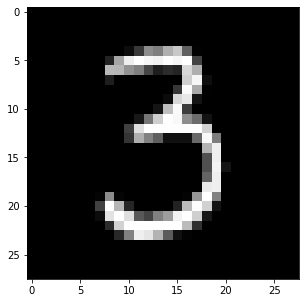

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[50])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

Definicion de funcion discriminadora, definiendo las rutas de salida para observar el comportamiento de datos comparados con otros


In [ ]:

class Discriminator(nn.Module):

 def __init__(self, input_size, hidden_dim, output_size):
     super(Discriminator, self).__init__()
     self.fc1 = nn.Linear(input_size, hidden_dim*4)
     self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
     self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
     self.fc4 = nn.Linear(hidden_dim, output_size)
     self.dropout = nn.Dropout(0.3)
 
 def forward(self, x):
     x = x.view(-1, 28*28)
     x = F.leaky_relu(self.fc1(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc2(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc3(x), 0.2)
     x = self.dropout(x)
     out = self.fc4(x)
     return out

Ya con el discriminador definido se pueden generar nuevos datos para que los pueda poner en comparacion con la funcion anterior, por lo que se define la funcion generadora 


In [ ]:
class Generator(nn.Module):
 def __init__(self, input_size, hidden_dim, output_size):
     super(Generator, self).__init__()
     self.fc1 = nn.Linear(input_size, hidden_dim)
     self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
     self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
     self.fc4 = nn.Linear(hidden_dim*4, output_size)
     self.dropout = nn.Dropout(0.3)
 
 def forward(self, x):
     x = F.leaky_relu(self.fc1(x), 0.2) 
     x = self.dropout(x)
     x = F.leaky_relu(self.fc2(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc3(x), 0.2)
     x = self.dropout(x)
    
     out = F.tanh(self.fc4(x))
     return out

  Se definen los parametros de salida que va contener el discriminador y el generador, por lo que se pueden escoger los datos que seran comparados con los generados con la funcion anterior
  

In [ ]:
input_size = 784
d_output_size = 1
d_hidden_size = 64


z_size = 100
g_output_size = 784
g_hidden_size = 64

In [ ]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Se define la funcion de perdida en comparacion ambos set de datos

In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

Se define el optimizador que se va a utilizar en el aprendizaje de la red

In [ ]:
lr = 0.001
d_optimizer = optim.RMSprop(D.parameters(), lr)
g_optimizer = optim.RMSprop(G.parameters(), lr)

Cuando se definen los set de datos y el optimizador se puede entrenar la red, por lo que se colocan los hiperparametros optimos para que pueda funcionar en ambos set de datos

In [ ]:
num_epochs = 50
samples = []
losses = []

print_every = 400
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
    
        real_images = real_images*2 - 1 
        d_optimizer.zero_grad()
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)     
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        g_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    losses.append((d_loss.item(), g_loss.item()))

    G.eval() 
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()



with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/   50] | d_loss: 1.3873 | g_loss: 0.7342
Epoch [    1/   50] | d_loss: 0.8908 | g_loss: 1.4693
Epoch [    1/   50] | d_loss: 1.1786 | g_loss: 1.1172
Epoch [    2/   50] | d_loss: 1.6944 | g_loss: 0.5970
Epoch [    2/   50] | d_loss: 1.0939 | g_loss: 1.4267
Epoch [    2/   50] | d_loss: 1.3763 | g_loss: 0.8547
Epoch [    3/   50] | d_loss: 1.3316 | g_loss: 1.2703
Epoch [    3/   50] | d_loss: 1.1341 | g_loss: 1.4868
Epoch [    3/   50] | d_loss: 1.2260 | g_loss: 0.8490
Epoch [    4/   50] | d_loss: 1.3561 | g_loss: 1.2669
Epoch [    4/   50] | d_loss: 1.2423 | g_loss: 1.1307
Epoch [    4/   50] | d_loss: 1.2359 | g_loss: 1.1884
Epoch [    5/   50] | d_loss: 1.3311 | g_loss: 0.8735
Epoch [    5/   50] | d_loss: 1.2674 | g_loss: 1.0611
Epoch [    5/   50] | d_loss: 1.2175 | g_loss: 1.1957
Epoch [    6/   50] | d_loss: 1.4575 | g_loss: 0.8271
Epoch [    6/   50] | d_loss: 1.2024 | g_loss: 1.0130
Epoch [    6/   50] | d_loss: 1.2288 | g_loss: 0.9809
Epoch [    7/   50] | d_loss

Se importa una grafica de Matploit para visualizar la perdida en el modelo

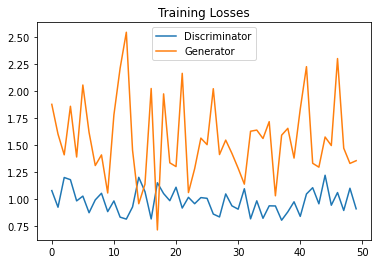

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

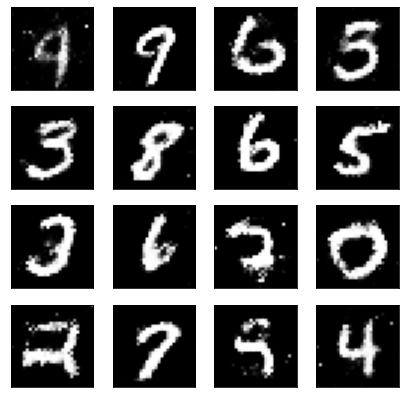

In [ ]:

def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)   
view_samples(-1, samples)       

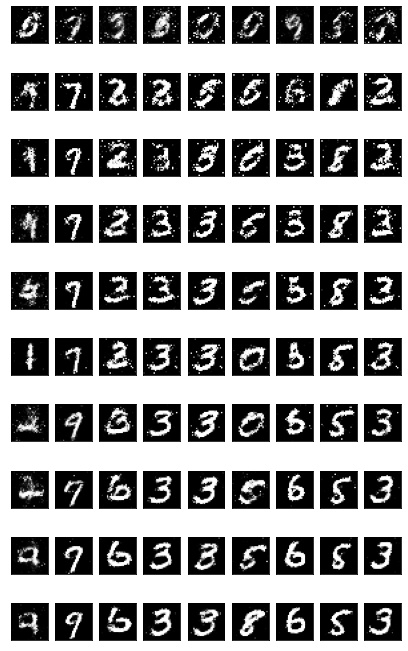

In [ ]:
rows = 10 
cols = 9
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

Identificacion de imagenes discriminadas

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


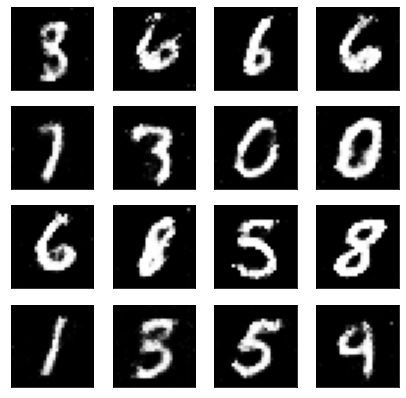

In [ ]:
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)


view_samples(0, [rand_images])

Importacion de set de datos FashionMNIST


In [ ]:
num_workers = 0
batch_size = 70

transform = transforms.ToTensor()

train_data = datasets.FashionMNIST(root="data", train=True,
 download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
 num_workers=num_workers)

Imagenes de entrenamiento

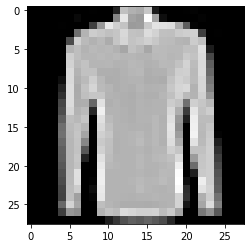

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[40])
fig = plt.figure(figsize = (4,4)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap="gray")

Definicion de funcion de discriminador

In [ ]:
class Discriminator(nn.Module):

 def __init__(self, input_size, hidden_dim, output_size):
     super(Discriminator, self).__init__()
     self.fc1 = nn.Linear(input_size, hidden_dim*4)
     self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
     self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
     self.fc4 = nn.Linear(hidden_dim, output_size)
     self.dropout = nn.Dropout(0.3)
 
 
 def forward(self, x):
     x = x.view(-1, 28*28)
     x = F.leaky_relu(self.fc1(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc2(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc3(x), 0.2)
     x = self.dropout(x)
     out = self.fc4(x)
     return out

Definicion de funcion generadora

In [ ]:
class Generator(nn.Module):
 def __init__(self, input_size, hidden_dim, output_size):
     super(Generator, self).__init__()
     self.fc1 = nn.Linear(input_size, hidden_dim)
     self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
     self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
     self.fc4 = nn.Linear(hidden_dim*4, output_size)
     self.dropout = nn.Dropout(0.3)
 
 def forward(self, x):
     x = F.leaky_relu(self.fc1(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc2(x), 0.2)
     x = self.dropout(x)
     x = F.leaky_relu(self.fc3(x), 0.2)
     x = self.dropout(x)
    
     out = F.tanh(self.fc4(x))
     return out

Determinacion de parametros de uso de datos para comparacion de datos en ambas funciones


In [ ]:
input_size = 784
d_output_size = 1
d_hidden_size = 64


z_size = 100
g_output_size = 784
g_hidden_size = 64

D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

Discriminator(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


Definicion de funcion de perdida

In [ ]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 

  
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) 
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

Funcion de optimizacion RMSprop

In [ ]:
lr = 0.001
d_optimizer = optim.RMSprop(D.parameters(), lr)
g_optimizer = optim.RMSprop(G.parameters(), lr)

Se entrena la red con los parametros correspondientes con respespecto a la funcion discriminadora y generadora de las imagenes

In [ ]:
num_epochs = 50
samples = []
losses = []

print_every = 400

sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()


D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
 
        real_images = real_images*2 - 1 
  
        d_optimizer.zero_grad()

        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)

        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

        g_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    losses.append((d_loss.item(), g_loss.item()))
    

    G.eval()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()


with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.2335 | g_loss: 1.1202
Epoch [    1/   50] | d_loss: 1.2861 | g_loss: 1.1119
Epoch [    1/   50] | d_loss: 1.3471 | g_loss: 0.8221
Epoch [    2/   50] | d_loss: 1.3043 | g_loss: 1.0489
Epoch [    2/   50] | d_loss: 1.3538 | g_loss: 0.8894
Epoch [    2/   50] | d_loss: 1.3301 | g_loss: 0.8491
Epoch [    3/   50] | d_loss: 1.3386 | g_loss: 1.4220
Epoch [    3/   50] | d_loss: 1.3239 | g_loss: 0.9223
Epoch [    3/   50] | d_loss: 1.3150 | g_loss: 0.9739
Epoch [    4/   50] | d_loss: 1.3452 | g_loss: 0.9364
Epoch [    4/   50] | d_loss: 1.3015 | g_loss: 0.9295
Epoch [    4/   50] | d_loss: 1.3390 | g_loss: 0.8508
Epoch [    5/   50] | d_loss: 1.3412 | g_loss: 0.9227
Epoch [    5/   50] | d_loss: 1.3094 | g_loss: 0.8342
Epoch [    5/   50] | d_loss: 1.3207 | g_loss: 0.8564
Epoch [    6/   50] | d_loss: 1.3735 | g_loss: 1.1365
Epoch [    6/   50] | d_loss: 1.3257 | g_loss: 0.9494
Epoch [    6/   50] | d_loss: 1.4104 | g_loss: 0.8455
Epoch [    7/   50] | d_loss

Se grafica e identificamos la perdida del modelo

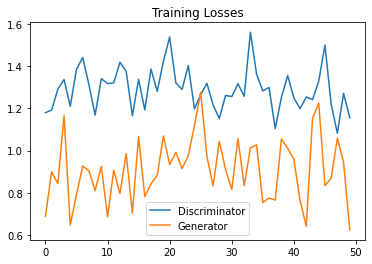

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

Imagenes de funcion 

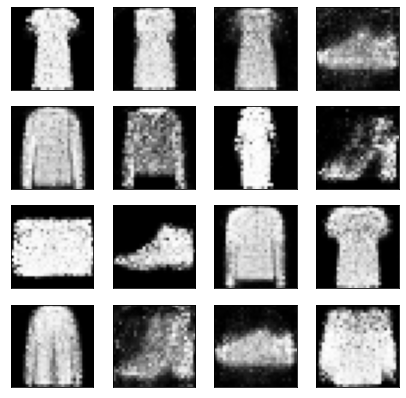

In [ ]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
view_samples(-1, samples)

Imagenes generadas

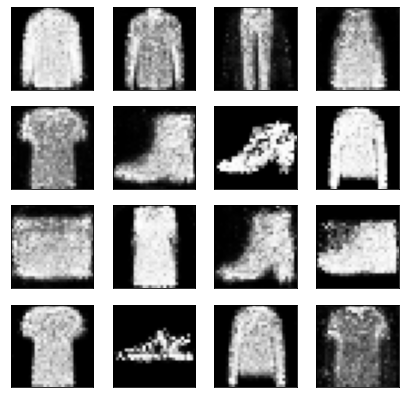

In [ ]:
sample_size=20
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() 
rand_images = G(rand_z)
view_samples(0, [rand_images])